In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import time


In [25]:
# sorting data from a file
datapath = "output/eye_data.csv"

# convert to dataframe
import pandas as pd
df = pd.read_csv(datapath)

df.head()

# open the output fodler and read all of the files

# create a list of all the image files
# and their labels
image_numbers = df['frame_idx'].tolist()
# load image
print("image_numbers", image_numbers[-1])

images = []
coords = []
coordsv = []
for idx, row in df.iterrows():
    if idx % 100 == 0:
        print(f"Processing {idx}/{len(df)}")
    frame_num = int(row['frame_idx'])
    image_path = f"output/{frame_num}.png"
    image = cv2.imread(image_path)
    if image is None:
        continue
    # convert to grayscale
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    h = image.shape[0]
    scale = 128 / h
    # resize the image to 128x128
    image = cv2.resize(image, (128, 128))/255
    images.append(image)
    coords.append((row['ellipse_x']/ h
                #    , row['ellipse_y']/h
                   ))
    coordsv.append(row['ellipse_y']/ h)

    # coords.append((row['ellipse_x'] * scale, row['ellipse_y'] * scale, row['ellipse_w'] * scale/2, row['ellipse_h'] * scale/2))



image_numbers 10389
Processing 0/10389
Processing 100/10389
Processing 200/10389
Processing 300/10389
Processing 400/10389
Processing 500/10389
Processing 600/10389
Processing 700/10389
Processing 800/10389
Processing 900/10389
Processing 1000/10389
Processing 1100/10389
Processing 1200/10389
Processing 1300/10389
Processing 1400/10389
Processing 1500/10389
Processing 1600/10389
Processing 1700/10389
Processing 1800/10389
Processing 1900/10389
Processing 2000/10389
Processing 2100/10389
Processing 2200/10389
Processing 2300/10389
Processing 2400/10389
Processing 2500/10389
Processing 2600/10389
Processing 2700/10389
Processing 2800/10389
Processing 2900/10389
Processing 3000/10389
Processing 3100/10389
Processing 3200/10389
Processing 3300/10389
Processing 3400/10389
Processing 3500/10389
Processing 3600/10389
Processing 3700/10389
Processing 3800/10389
Processing 3900/10389
Processing 4000/10389
Processing 4100/10389
Processing 4200/10389
Processing 4300/10389
Processing 4400/10389
Pr

In [26]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, coords, test_size=0.2, random_state=42)
X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
X_test  = np.array(X_test, dtype=np.float32)
y_test  = np.array(y_test, dtype=np.float32)

X_trainv, X_testv, y_trainv, y_testv = train_test_split(images, coordsv, test_size=0.2, random_state=42)
X_trainv = np.array(X_trainv, dtype=np.float32)
y_trainv = np.array(y_trainv, dtype=np.float32)
X_testv  = np.array(X_testv, dtype=np.float32)
y_testv  = np.array(y_testv, dtype=np.float32)
def build_model(input_shape=(128,128,1)):
    inputs = layers.Input(shape=input_shape)

    # Encoder: 3 × (Conv → ReLU → MaxPool)
    x = layers.Conv2D(32, 7, padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D(2)(x)   # 64×64×32

    x = layers.Conv2D(64, 5, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)   # 32×32×64

    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling2D(2)(x)   # 16×16×128

    # Flatten and dense head
    x = layers.Flatten()(x)         # 16*16*128 = 32768
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='linear')(x)  # (x, y)

    model = models.Model(inputs, outputs, name="CoordNet")
    return model

model = build_model()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()




Model: "CoordNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_36 (Conv2D)          (None, 128, 128, 32)      1600      
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 64, 64, 64)        51264     
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 32, 32, 128)       738

In [27]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(patience=10, restore_best_weights=True)

model = build_model()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
modelv = build_model()
modelv.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)

loss, mae = model.evaluate(X_test, y_test)

# print("Actual coords:", y_test[:100])

# find mean absolute error for the x and y coordinates



Epoch 1/50
260/260 [==============================] - 5s 19ms/step - loss: 0.1568 - mae: 0.1139 - val_loss: 0.0029 - val_mae: 0.0475
Epoch 2/50
260/260 [==============================] - 4s 16ms/step - loss: 0.0080 - mae: 0.0710 - val_loss: 6.9660e-04 - val_mae: 0.0198
Epoch 3/50
260/260 [==============================] - 4s 15ms/step - loss: 0.0067 - mae: 0.0654 - val_loss: 3.5650e-04 - val_mae: 0.0141
Epoch 4/50
260/260 [==============================] - 3s 12ms/step - loss: 0.0063 - mae: 0.0634 - val_loss: 3.0054e-04 - val_mae: 0.0124
Epoch 5/50
260/260 [==============================] - 3s 10ms/step - loss: 0.0055 - mae: 0.0589 - val_loss: 4.0131e-04 - val_mae: 0.0160
Epoch 6/50
260/260 [==============================] - 3s 10ms/step - loss: 0.0051 - mae: 0.0575 - val_loss: 3.9648e-04 - val_mae: 0.0161
Epoch 7/50
260/260 [==============================] - 3s 10ms/step - loss: 0.0046 - mae: 0.0542 - val_loss: 3.3691e-04 - val_mae: 0.0149
Epoch 8/50
260/260 [=========================

In [28]:
modelv.fit(
    X_trainv, y_trainv,
    validation_data=(X_testv, y_testv),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)
lossv, maev = modelv.evaluate(X_testv, y_testv)


Epoch 1/50
260/260 [==============================] - 4s 12ms/step - loss: 0.1407 - mae: 0.1041 - val_loss: 0.0022 - val_mae: 0.0397
Epoch 2/50
260/260 [==============================] - 3s 10ms/step - loss: 0.0055 - mae: 0.0594 - val_loss: 7.4751e-04 - val_mae: 0.0205
Epoch 3/50
260/260 [==============================] - 3s 11ms/step - loss: 0.0053 - mae: 0.0575 - val_loss: 4.9061e-04 - val_mae: 0.0148
Epoch 4/50
260/260 [==============================] - 3s 10ms/step - loss: 0.0049 - mae: 0.0554 - val_loss: 5.6367e-04 - val_mae: 0.0191
Epoch 5/50
260/260 [==============================] - 3s 11ms/step - loss: 0.0042 - mae: 0.0518 - val_loss: 4.5059e-04 - val_mae: 0.0164
Epoch 6/50
260/260 [==============================] - 3s 11ms/step - loss: 0.0039 - mae: 0.0501 - val_loss: 2.9692e-04 - val_mae: 0.0129
Epoch 7/50
260/260 [==============================] - 3s 10ms/step - loss: 0.0033 - mae: 0.0457 - val_loss: 7.6554e-04 - val_mae: 0.0238
Epoch 8/50
260/260 [=========================

1/1 [==============================] - 0s 36ms/step
Actual x: 73.53087615966797, Predicted x: [73.14679]
Actual y: 52.54981231689453, Predicted y: [52.98844]


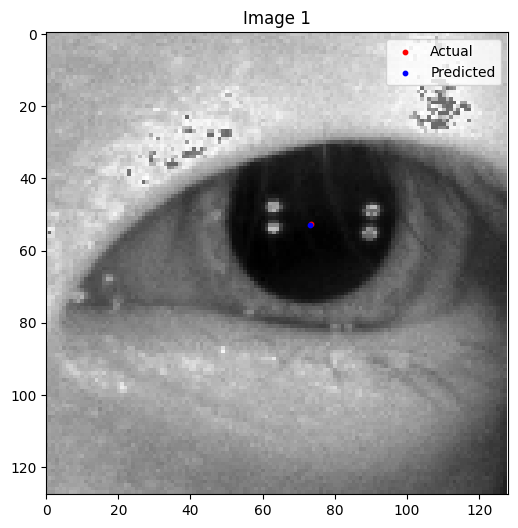

Actual x: 68.72235870361328, Predicted x: [67.38212]
Actual y: 56.69356918334961, Predicted y: [56.89555]


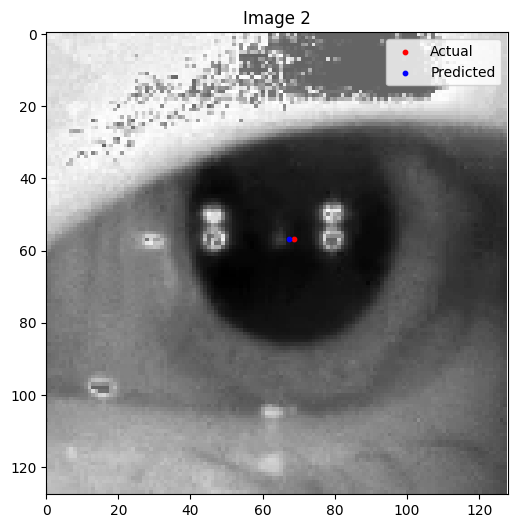

Actual x: 67.80130004882812, Predicted x: [67.42255]
Actual y: 62.451541900634766, Predicted y: [62.16687]


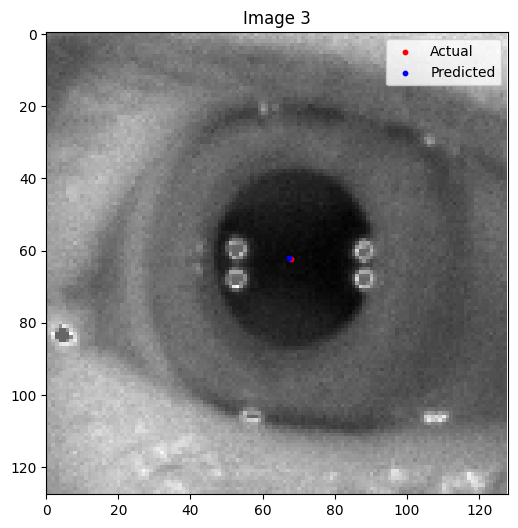

Actual x: 62.696266174316406, Predicted x: [63.176785]
Actual y: 73.27812194824219, Predicted y: [72.42955]


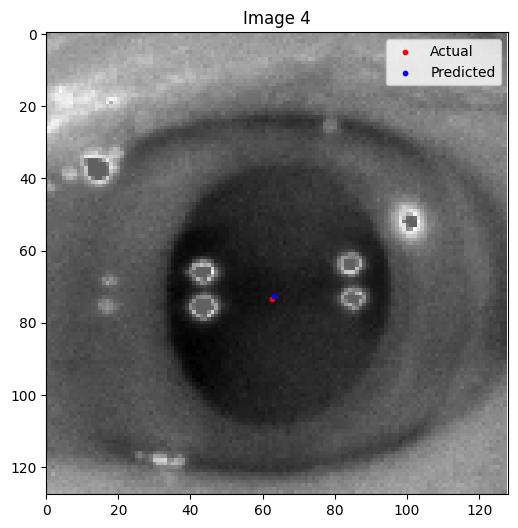

Actual x: 77.77034759521484, Predicted x: [77.53148]
Actual y: 61.538719177246094, Predicted y: [60.902584]


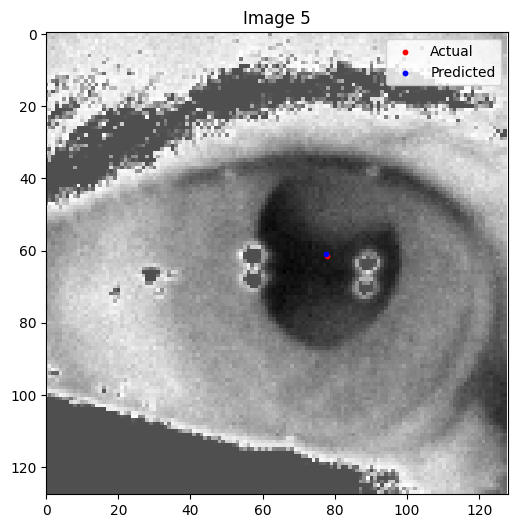

Actual x: 70.423828125, Predicted x: [70.691696]
Actual y: 64.14286041259766, Predicted y: [64.171135]


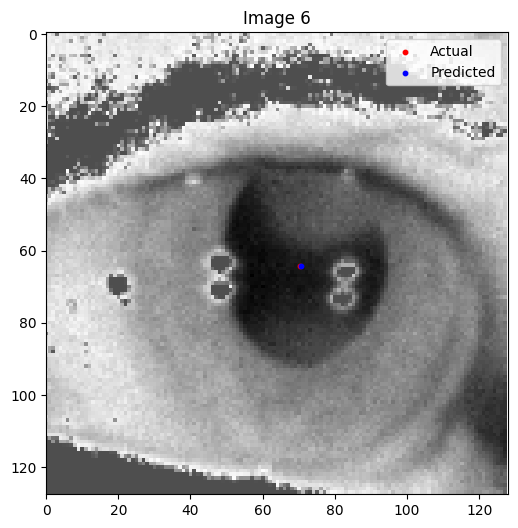

Actual x: 71.45280456542969, Predicted x: [71.86743]
Actual y: 61.901981353759766, Predicted y: [61.637486]


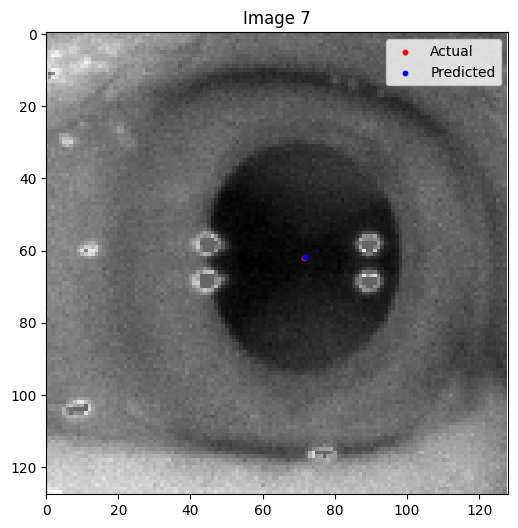

Actual x: 69.57487487792969, Predicted x: [70.23374]
Actual y: 64.66053009033203, Predicted y: [64.246796]


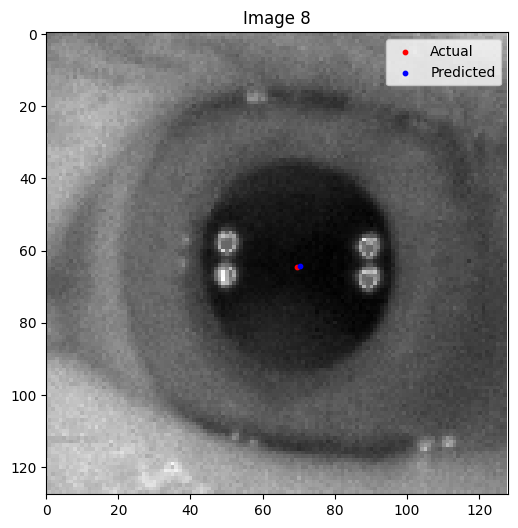

Actual x: 74.60298919677734, Predicted x: [74.79106]
Actual y: 60.87793731689453, Predicted y: [60.124466]


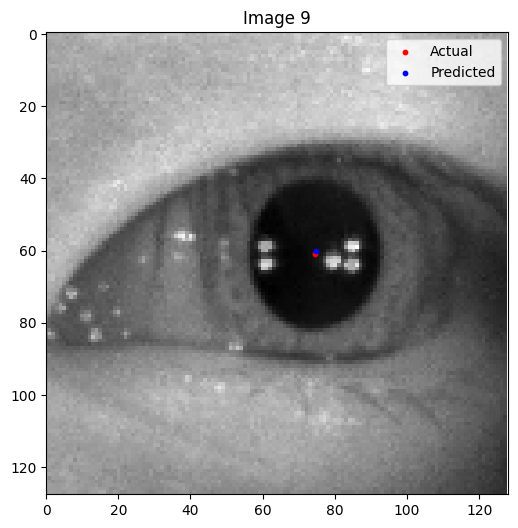

Actual x: 66.39999389648438, Predicted x: [67.94186]
Actual y: 68.08202362060547, Predicted y: [67.45087]


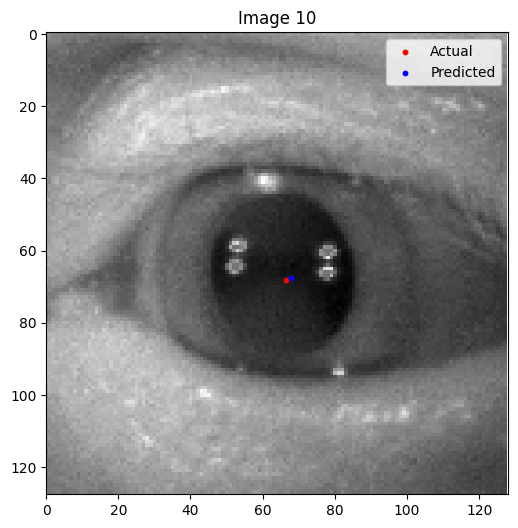

In [37]:
# plot first 5 predictions against the actual coordinates
preds = model.predict(X_test[:10])
predsv = modelv.predict(X_testv[:10])
for i in range(10):
    plt.figure(figsize=(6, 6))
    plt.imshow(X_test[i].reshape(128, 128), cmap='gray')
    plt.scatter(y_test[i]*128, y_testv[i]*128, color='red', label='Actual', s=10)
    plt.scatter(preds[i]*128, predsv[i]*128, color='blue', label='Predicted', s=10)

    print(f"Actual x: {y_test[i]*128}, Predicted x: {preds[i]*128}")
    print(f"Actual y: {y_testv[i]*128}, Predicted y: {predsv[i]*128}")
    plt.xlim(0, 128)

    plt.title(f"Image {i+1}")
    plt.legend()
    plt.show()

In [35]:
# save CNN
model.save("eye_tracking_model.keras", include_optimizer=False)
modelv.save("eye_tracking_modelv.keras", include_optimizer=False)
# save as tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open("eye_tracking_model.tflite", "wb") as f:
    f.write(tflite_model)
# save as tflite
converterv = tf.lite.TFLiteConverter.from_keras_model(modelv)
tflite_modelv = converterv.convert()
with open("eye_tracking_modelv.tflite", "wb") as f:
    f.write(tflite_modelv)
# 


INFO:tensorflow:Assets written to: C:\Users\NateLy\AppData\Local\Temp\tmp9fuf2qc9\assets


INFO:tensorflow:Assets written to: C:\Users\NateLy\AppData\Local\Temp\tmp9fuf2qc9\assets


INFO:tensorflow:Assets written to: C:\Users\NateLy\AppData\Local\Temp\tmpsqbzfyg3\assets


INFO:tensorflow:Assets written to: C:\Users\NateLy\AppData\Local\Temp\tmpsqbzfyg3\assets


In [31]:
# # go through images and show video



# while True:
#     for idx, row in df.iterrows():
#         if idx % 100 == 0:
#             print(f"Processing {idx}/{len(df)}")
#         frame_num = int(row['frame_idx'])
#         image_path = f"output/{frame_num}.png"
#         image = cv2.imread(image_path)
#         if image is None:
#             continue
#         # convert to grayscale
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#         h = image.shape[0]
#         scale = 128 / h
#         # resize the image to 128x128
#         image = cv2.resize(image, (128, 128))/255
#         image = np.expand_dims(image, axis=-1)  # Add channel dimension

#         pred = model.predict(np.array([image]))
#         predv = modelv.predict(np.array([image]))

#         # draw the predicted coordinates on the image
#         x, y = int(pred[0][0] * 128), int(predv[0][0] * 128)
#         cv2.circle(image, (x, y), 2, (255, 0, 0), -1)

#         cv2.imshow("Eye Tracking", image)
#         if cv2.waitKey(1) & 0xFF == ord('q'):
#             break